# Object detection - how to draw bounding boxes

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model

from PIL import Image
import cv2

In [96]:
# .h5 file which model team made
model_path = "C:/Users/yukic/Documents/ADA/model_1_5_epoch.h5"
# our first detecting object
image = "first_task.png"

# input size of what model team made
input_size = 32
channel = 3

# label that model team used
label_name = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

test_size = 160

cutoff = 0.6

## Test data

Test data shape: (160, 160, 3)
Picture size: (160, 160)
Color channel: RGB


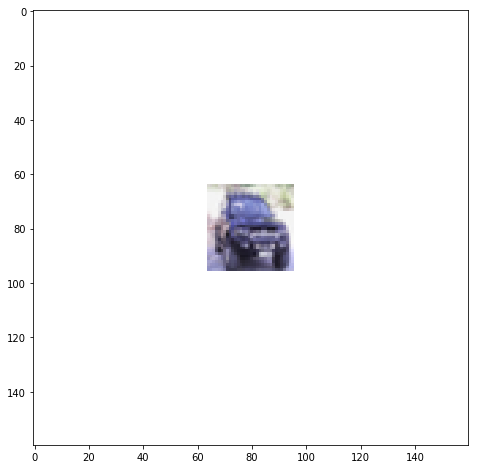

In [3]:
img = Image.open(image)
# change color channel from 4 to 3 for model
img = img.convert("RGB")

print("Test data shape:", np.array(img).shape)
print("Picture size:", img.size)
print("Color channel:", img.mode)
plt.figure(figsize = (8, 8))
plt.imshow(img)
plt.show()

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


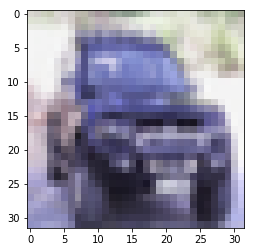

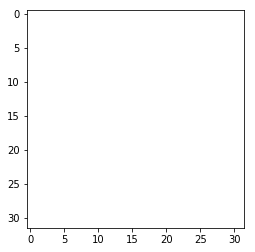

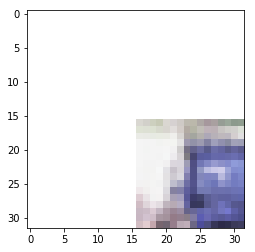

In [4]:
img_ar = np.array(img)

# extract middle part from the image
middle = img_ar[64:96, 64:96, :]
# extract top left part from the image
topleft = img_ar[:32, :32, :]
# extract middle a bit slided
mix = img_ar[48:80, 48:80, :]

print(middle.shape)
print(topleft.shape)
print(mix.shape)

plt.imshow(middle)
plt.show()
plt.imshow(topleft)
plt.show()
plt.imshow(mix)
plt.show()

## Model

In [5]:
loaded_model = load_model(model_path)
loaded_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3686912   
_______________________________________

## Preprocessing

In [6]:
middle_proc = middle.reshape((1, input_size, input_size, channel))
print(middle_proc.shape)

(1, 32, 32, 3)


In [7]:
middle_proc = middle_proc.astype("float32")
middle_proc /= 255

In [8]:
# do the same for other images
topleft_proc = topleft.reshape((1, input_size, input_size, channel))
topleft_proc = topleft_proc.astype("float32")
topleft_proc /= 255

mix_proc = mix.reshape((1, input_size, input_size, channel))
mix_proc = mix_proc.astype("float32")
mix_proc /= 255

## Prediction

In [9]:
pred_middle = loaded_model.predict(middle_proc)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_middle, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.003
1,automobile,0.378
2,bird,0.000
3,cat,0.001
4,deer,0.001
5,dog,0.000
6,frog,0.001
7,horse,0.000
8,ship,0.030
9,truck,0.023


In [10]:
pred_topleft = loaded_model.predict(topleft_proc)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_topleft, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.097
1,automobile,0.000
2,bird,0.014
3,cat,0.038
4,deer,0.001
5,dog,0.008
6,frog,0.001
7,horse,0.000
8,ship,0.009
9,truck,0.000


In [11]:
pred_mix = loaded_model.predict(mix_proc)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_mix, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.067
1,automobile,0.000
2,bird,0.008
3,cat,0.033
4,deer,0.002
5,dog,0.017
6,frog,0.001
7,horse,0.000
8,ship,0.041
9,truck,0.000


## Sliding windows example

In [12]:
# preprocessing
print(img_ar.shape)
img_proc = img_ar.reshape((-1, test_size, test_size, channel))
print(img_proc.shape)
img_proc = img_proc.astype("float32")
img_proc /= 255

(160, 160, 3)
(1, 160, 160, 3)


In [13]:
tmp = img_proc[:, :32, :32, :]
pred_tmp = loaded_model.predict(tmp)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_tmp, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.097
1,automobile,0.000
2,bird,0.014
3,cat,0.038
4,deer,0.001
5,dog,0.008
6,frog,0.001
7,horse,0.000
8,ship,0.009
9,truck,0.000


In [14]:
tmp = img_proc[:, :32, :32, :]
pred_tmp = loaded_model.predict(tmp)
idx_max = np.argmax(pred_tmp)
print(idx_max)

0


Out test case has 160 pixel widths. Our model has 32 pixel input widths. 160 - 32 = 128. Suppose we silde 1 pixel by 1 pixel. So we can make 128 + 1 predictions when we slide horizontally. The vertical direction is the same, so we can make (128 + 1) * (128 + 1) = 16,641 predictions in total.

In [15]:
counter = 0
tmp = img_proc[:, :(input_size+counter), :(input_size+counter), :]
pred_tmp = loaded_model.predict(tmp)
idx_max = np.argmax(pred_tmp)
print(idx_max)

counter += 1
print(counter)

tmp = img_proc[:, counter:(input_size+counter), counter:(input_size+counter), :]
pred_tmp = loaded_model.predict(tmp)
idx_max = np.argmax(pred_tmp)
print(idx_max)

0
1
0


In [17]:
for i in range(129):
    tmp = img_proc[:, 64:96, i:(input_size+i), :]
    pred_tmp = loaded_model.predict(tmp)
    idx_max = np.argmax(pred_tmp)
    prob_max = np.max(pred_tmp)
    print(np.round(prob_max, decimals = 2))

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.08
0.05
0.05
0.05
0.06
0.07
0.06
0.06
0.08
0.1
0.08
0.06
0.09
0.09
0.09
0.06
0.04
0.04
0.05
0.07
0.05
0.07
0.05
0.06
0.06
0.06
0.08
0.12
0.1
0.22
0.24
0.38
0.36
0.28
0.09
0.04
0.05
0.06
0.1
0.12
0.17
0.15
0.13
0.12
0.14
0.15
0.14
0.11
0.08
0.08
0.11
0.14
0.17
0.18
0.17
0.17
0.15
0.14
0.1
0.08
0.06
0.07
0.09
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


In [16]:
for i in range(129):
    # fix vertical
    tmp = img_proc[:, 64:96, i:(input_size+i), :]
    pred_tmp = loaded_model.predict(tmp)
    idx_max = np.argmax(pred_tmp)
    print(idx_max)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
3
5
5
5
5
5
5
0
4
2
2
2
2
2
0
8
8
8
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


## Prediction all over the places with sliding window

In [19]:
# predict all over the place
idx_matrix = np.zeros((129, 129))
prob_matrix = np.zeros((129, 129))

for j in range(129):

    for i in range(129):
        tmp = img_proc[:, j:(input_size+j), i:(input_size+i), :]
        pred_tmp = loaded_model.predict(tmp)
        idx_max = np.argmax(pred_tmp)
        prob_max = np.max(pred_tmp)

        # store values
        idx_matrix[j, i] = idx_max
        prob_matrix[j, i] = prob_max

Taking too much time, around 1 min

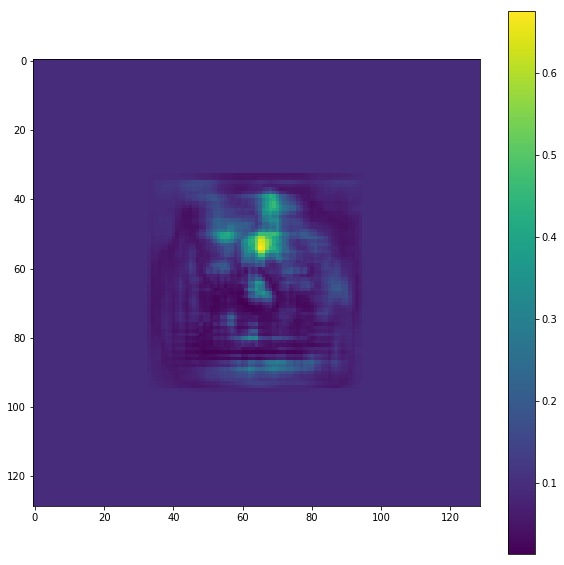

In [20]:
plt.figure(figsize = (10, 10))
plt.imshow(prob_matrix)
plt.colorbar()
plt.show()

## Bounding boxes

If you have appropriate pt1 and pt2 coordinate information, you can draw an appropriate bounding box.

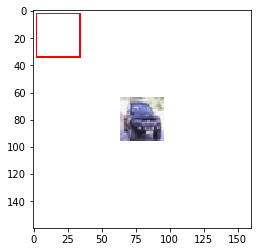

In [72]:
# example
tmp = cv2.rectangle(img = np.array(img), pt1 = (2, 2), pt2 = (34, 34), color = (255, 0, 0), thickness = 1)
plt.imshow(tmp)
plt.show()

In [46]:
print("Maximum probability", prob_matrix.max())
print("Location with max prob", np.where(prob_matrix.max() == prob_matrix))
print("Checking", prob_matrix[54, 65])

Maximum probability 0.676719605922699
Location with max prob (array([54], dtype=int64), array([65], dtype=int64))
Checking 0.676719605922699


We predicted with the following logic; 
<br>
"
<br>
for j in range(129): 
<br>
for i in range(129): 
<br>
img_proc[:, j:(input_size+j), i:(input_size+i), :]
<br>
"
<br>
So prob_matrix[54, 65] means that our test image was [:, 54:(32+54), 65:(32+65), :] = [:, 54:86, 65:97, :]

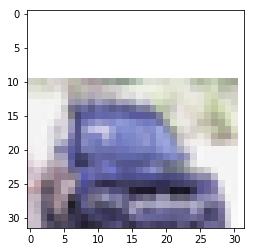

In [56]:
# a part of the image which has the maximum probability
tmp = img_ar[54:86, 65:97, :]
plt.imshow(tmp)
plt.show()

Let's draw a bounding box to the image with which we have the maximum probability.

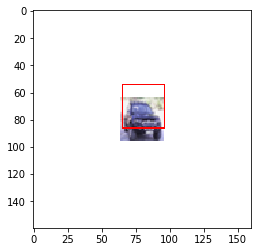

In [71]:
tmp_2 = cv2.rectangle(img = np.array(img), pt1 = (65, 54), pt2 = (96, 86), color = (255, 0, 0), thickness = 1)
plt.imshow(tmp_2)
plt.show()

Notice that our numpy array index starts from the North West, but the coordinate of OpenCV starts from the South West.

## Object detection

In [98]:
# shape of original image and prediction matrix are different
print(prob_matrix.shape)
print(np.array(img).shape)

(129, 129)
(160, 160, 3)


In [106]:
prob_array = prob_matrix.flatten(order = "C")

length = len(prob_array)

location = []

for i in range(129):
    
    for j in range(129):
        
        tmp = [i, j, (input_size + i), (input_size + j)]
        location.append(tmp)

In [107]:
# number of bounding boxes with prespecified cutoff
print(sum(prob_array > cutoff))
confident_location = np.array(location)[prob_array > cutoff]
print(confident_location)

7
[[52 65 84 97]
 [52 66 84 98]
 [53 65 85 97]
 [53 66 85 98]
 [54 65 86 97]
 [54 66 86 98]
 [55 66 87 98]]


Number of bounding boxes:  7


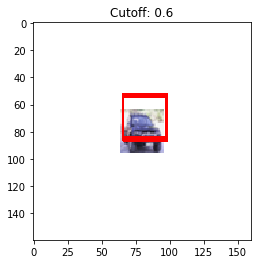

In [108]:
print("Number of bounding boxes:", sum(prob_array > cutoff))

tmp = np.array(img)

for pt1_1, pt1_2, pt2_1, pt2_2 in confident_location:
    tmp = cv2.rectangle(img = tmp, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 1)
    
plt.imshow(tmp)
plt.title("Cutoff: {}".format(cutoff))
plt.show()

## Cutoff adjustment

Number of bounding boxes:  58


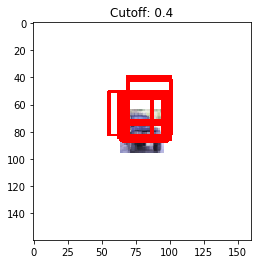

In [109]:
# adjust cutoff
cutoff_adj = 0.40

# number of bounding boxes
print("Number of bounding boxes:", sum(prob_array > cutoff_adj))

# update confident location
confident_location = np.array(location)[prob_array > cutoff_adj]

tmp_1 = np.array(img)

for pt1_1, pt1_2, pt2_1, pt2_2 in confident_location:
    tmp_1 = cv2.rectangle(img = tmp_1, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 1)
    
plt.imshow(tmp_1)
plt.title("Cutoff: {}".format(cutoff_adj))
plt.show()

Number of bounding boxes: 84


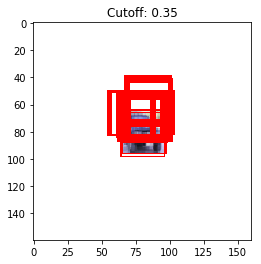

In [110]:
# adjust cutoff
cutoff_adj = 0.35

# number of bounding boxes
print("Number of bounding boxes:", sum(prob_array > cutoff_adj))

# update confident location
confident_location = np.array(location)[prob_array > cutoff_adj]

tmp_2 = np.array(img)

for pt1_1, pt1_2, pt2_1, pt2_2 in confident_location:
    tmp_2 = cv2.rectangle(img = tmp_2, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 1)
    
plt.imshow(tmp_2)
plt.title("Cutoff: {}".format(cutoff_adj))
plt.show()

## Boxes suppression with simple logic

In [119]:
cutoff_adj = 0.35
confident_location = np.array(location)[prob_array > cutoff_adj]
print("Head \n", confident_location[:3, :])
n = confident_location.shape[0]
print("Tail \n", confident_location[(n-3):(n+1), :])

Head 
 [[ 39  67  71  99]
 [ 39  68  71 100]
 [ 39  69  71 101]]
Tail 
 [[64 64 96 96]
 [64 65 96 97]
 [66 64 98 96]]


In [130]:
loc_1 = []

for i in range(n):
    loc_1.append(confident_location[i][0])
    
loc_2 = []

for i in range(n):
    loc_2.append(confident_location[i][1])
    
loc_3 = []

for i in range(n):
    loc_3.append(confident_location[i][2])
    
loc_4 = []

for i in range(n):
    loc_4.append(confident_location[i][3])
    
loc_all = []
loc_all.append(np.min(loc_1))
loc_all.append(np.min(loc_2))
loc_all.append(np.max(loc_3))
loc_all.append(np.max(loc_4))

print(loc_all)

[39, 54, 98, 103]


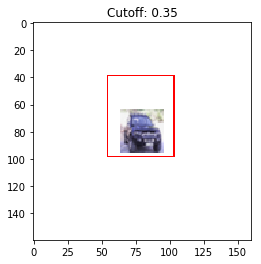

In [131]:
cutoff_adj = 0.35
tmp_3 = np.array(img)

pt1_1, pt1_2, pt2_1, pt2_2 = loc_all
tmp_3 = cv2.rectangle(img = tmp_3, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 1)
    
plt.imshow(tmp_3)
plt.title("Cutoff: {}".format(cutoff_adj))
plt.show()

## False positive

In [198]:
cutoff_adj = 0.35
loc_id = 0
confident_location = np.array(location)[prob_array > cutoff_adj]
confident_probability = prob_array[prob_array > cutoff_adj]

idx_array = idx_matrix.flatten(order = "C")
confident_label = idx_array[prob_array > cutoff_adj]


# extract
tmp_pt_1, tmp_pt_2, tmp_pt_3, tmp_pt_4 = confident_location[loc_id]
img_ar = np.array(img)
fp_1 = img_ar[tmp_pt_1:(tmp_pt_3+1), tmp_pt_2:(tmp_pt_4+1), :]

label_fp_1 = label_name[int(confident_label[loc_id])]
prob_fp_1 = np.round(confident_probability[loc_id], decimals = 2)

# plt.imshow(fp_1)
# plt.title("Pred: {}, Prob: {}".format(label_fp_1, prob_fp_1))
# plt.show()

In [199]:
cutoff_adj = 0.35
loc_id = 20
confident_location = np.array(location)[prob_array > cutoff_adj]
confident_probability = prob_array[prob_array > cutoff_adj]

idx_array = idx_matrix.flatten(order = "C")
confident_label = idx_array[prob_array > cutoff_adj]


# extract
tmp_pt_1, tmp_pt_2, tmp_pt_3, tmp_pt_4 = confident_location[loc_id]
img_ar = np.array(img)
fp_2 = img_ar[tmp_pt_1:(tmp_pt_3+1), tmp_pt_2:(tmp_pt_4+1), :]

label_fp_2 = label_name[int(confident_label[loc_id])]
prob_fp_2 = np.round(confident_probability[loc_id], decimals = 2)

# plt.imshow(fp_2)
# plt.title("Pred: {}, Prob: {}".format(label_fp_2, prob_fp_2))
# plt.show()

In [200]:
cutoff_adj = 0.35
loc_id = 81
confident_location = np.array(location)[prob_array > cutoff_adj]
confident_probability = prob_array[prob_array > cutoff_adj]

idx_array = idx_matrix.flatten(order = "C")
confident_label = idx_array[prob_array > cutoff_adj]


# extract
tmp_pt_1, tmp_pt_2, tmp_pt_3, tmp_pt_4 = confident_location[loc_id]
img_ar = np.array(img)
fp_3 = img_ar[tmp_pt_1:(tmp_pt_3+1), tmp_pt_2:(tmp_pt_4+1), :]

label_fp_3 = label_name[int(confident_label[loc_id])]
prob_fp_3 = np.round(confident_probability[loc_id], decimals = 2)

# plt.imshow(fp_3)
# plt.title("Pred: {}, Prob: {}".format(label_fp_3, prob_fp_3))
# plt.show()

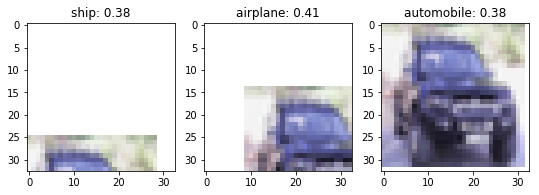

In [201]:
plt.figure(figsize = (9, 3))

plt.subplot(131)
plt.imshow(fp_1)
plt.title("{}: {}".format(label_fp_1, prob_fp_1))

plt.subplot(132)
plt.imshow(fp_2)
plt.title("{}: {}".format(label_fp_2, prob_fp_2))

plt.subplot(133)
plt.imshow(fp_3)
plt.title("{}: {}".format(label_fp_3, prob_fp_3))

plt.show()